In [30]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# 下載股票數據
def download_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Close']]

# 資料預處理
def preprocess_data(data, time_step=60):
    data_values = data.values
    x_data, y_data = [], []
    for i in range(time_step, len(data_values)):
        x_data.append(data_values[i-time_step:i, 0])
        y_data.append(data_values[i, 0])
    
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    # 切分訓練集和測試集
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    
    # 將數據轉換為 PyTorch 的 Tensor，並傳到 GPU
    x_train = torch.from_numpy(x_train).float().unsqueeze(-1).to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_test = torch.from_numpy(x_test).float().unsqueeze(-1).to(device)
    y_test = torch.from_numpy(y_test).float().to(device)
    
    return x_train, y_train, x_test, y_test

In [33]:
# 定義 LSTM 模型
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=256, output_size=1):
        super(StockLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1])  # 只取最後一個時間步的輸出
        return predictions

In [34]:
# 訓練模型
def train_model(model, x_train, y_train, x_test, y_test, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # 評估模型
        model.eval()
        with torch.no_grad():
            test_pred = model(x_test)
            test_loss = criterion(test_pred.squeeze(), y_test)
            test_losses.append(test_loss.item())
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item()}, Test Loss: {test_loss.item()}")
    
    return train_losses, test_losses

# 繪製結果
def plot_predictions(model, x_train, y_train, x_test, y_test, date_train, date_test):
    model.eval()
    with torch.no_grad():
        train_pred = model(x_train).squeeze().cpu().numpy()
        test_pred = model(x_test).squeeze().cpu().numpy()
    
    plt.figure(figsize=(16,8))
    plt.title('Stock Price Prediction using LSTM (PyTorch)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    
    # 繪製訓練資料的實際值和預測值
    plt.plot(date_train, y_train.cpu(), label='Train Data')
    plt.plot(date_test, y_test.cpu(), label='Test Data')
    plt.plot(date_test, test_pred, label='Predictions')
    
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()

In [41]:
ticker = '2330.TW'
start_date = '2018-01-01'
end_date = '2024-03-01'
time_step = 60  # 自訂時間窗格

data = download_stock_data(ticker, start_date, end_date)
data = data.dropna()
x_train, y_train, x_test, y_test = preprocess_data(data, time_step)
train_size = len(y_train)

date_train = data.index[:train_size]
date_test = data.index[train_size:-(time_step)]

[*********************100%***********************]  1 of 1 completed


In [36]:
# 初始化和訓練模型，並將模型轉移到 GPU
model = StockLSTM().to(device)
train_losses, test_losses = train_model(model, x_train, y_train, x_test, y_test, epochs=10000)

Epoch 0, Train Loss: 187063.546875, Test Loss: 305040.21875
Epoch 10, Train Loss: 185584.765625, Test Loss: 303108.8125
Epoch 20, Train Loss: 184098.59375, Test Loss: 301156.875
Epoch 30, Train Loss: 181763.859375, Test Loss: 298128.5625
Epoch 40, Train Loss: 178853.484375, Test Loss: 293818.4375
Epoch 50, Train Loss: 176545.015625, Test Loss: 290658.6875
Epoch 60, Train Loss: 174726.234375, Test Loss: 288194.125
Epoch 70, Train Loss: 172881.546875, Test Loss: 285657.125
Epoch 80, Train Loss: 170873.25, Test Loss: 282901.03125
Epoch 90, Train Loss: 168881.375, Test Loss: 280126.5625
Epoch 100, Train Loss: 166988.78125, Test Loss: 277507.34375
Epoch 110, Train Loss: 165213.546875, Test Loss: 275065.375
Epoch 120, Train Loss: 163441.734375, Test Loss: 272616.6875
Epoch 130, Train Loss: 161654.71875, Test Loss: 270122.75
Epoch 140, Train Loss: 159895.515625, Test Loss: 267678.4375
Epoch 150, Train Loss: 158169.015625, Test Loss: 265295.625
Epoch 160, Train Loss: 156452.203125, Test Loss: 

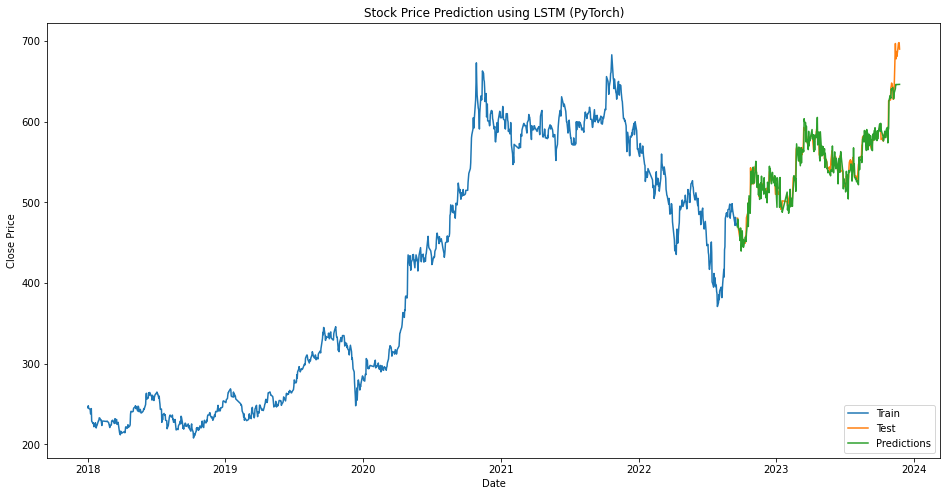

In [42]:
# 繪製結果
plot_predictions(model, x_train, y_train, x_test, y_test, date_train, date_test)